# **Problem set 2** - Machine Learning for Physics and Astronomy 2023/2024, UvA
---




- The total sheet gives 26 points
- Deadline for submitting your results is **Wed 17/04/2024, 23:59**
- **IMPORTANT**: Specify if/how AI was used to solve the exercises by filling the corresponding "Usage of AI" comments. Anything between "No" (if applicable) and a short paragraph reflecting how AI was used is fine. Failing to do so faithfully will result in the substraction of points.

### **Maxwell A. Fine**
### **14880725**

## Chapter 3: Inference and Bayes nets (16 points)

*Topics: Inverse transform sampling*

**Reading material: Murphy 23.2.1**

### 3.1 Inverse Sampling (2 points)

(2 points) Consider the target exponential pdf $p(x)=\lambda e^{-\lambda x}$, where $\lambda$ is the rate parameter. Define a function that, using the inverse transform method, generates samples from the exponential distribution.

Choosing $\lambda =0.5$ and a sample size of $1000$, plot the histogram of the sampled data and overlay the theoretical exponential distribution curve on top.

Hint: You will need to use the function `np.random.uniform`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def inverse_transform(rate, sample_size):
  """
    Generate random samples from an exponential distribution using the inverse transform method.

    Parameters:
    rate (float): The rate parameter (λ) of the exponential distribution.
    sample_size (int): The number of samples to generate.

    Returns:
    numpy.ndarray: An array containing random samples drawn from the exponential distribution.

    Explanation:
    This function generates random samples from an exponential distribution with the specified rate parameter 
    using the inverse transform method. 
    It computes the cumulative distribution function (CDF) analytically, 
    then generates samples by transforming uniform random variables into the 
    corresponding quantiles of the exponential distribution.
    
    Algorithm:
    1. Generate a range of values for x_arr from 0 to 7/rate, representing the decay times.
    2. Compute the cumulative distribution function (CDF) using the formula: 1 - exp(-rate * x_arr).
    3. Generate 'sample_size' random samples by selecting the closest x_arr value corresponding
    to a uniformly distributed random number between 0 and 1 of the CDF.
    4. Return the generated samples.
  """
  # how to define x_arr so it works
  # I am assuming x is only positive  

  x_arr = np.linspace(0, 7/rate, 3*sample_size) # goes from 0, to 7 decay times
  # now make cdf integrating from 0 to x, this is analyitical 
  cdf = 1 - np.exp(-rate*x_arr)

  samples = np.zeros(sample_size)
  for i in range(sample_size): # TODO  not sure if I can get rid of the forloop
    uniform_sample = np.random.uniform() # between 0-1
    # the unfirom sample corresponds to our CDF
    # we want the closest cdf, and then our random sample is that x_arr value
    index_val = np.argmin(np.abs(uniform_sample - cdf))
    samples[i] = x_arr[index_val]
    
  return samples


Text(0.5, 1.0, 'Sampled data vs Theoretical PDF')

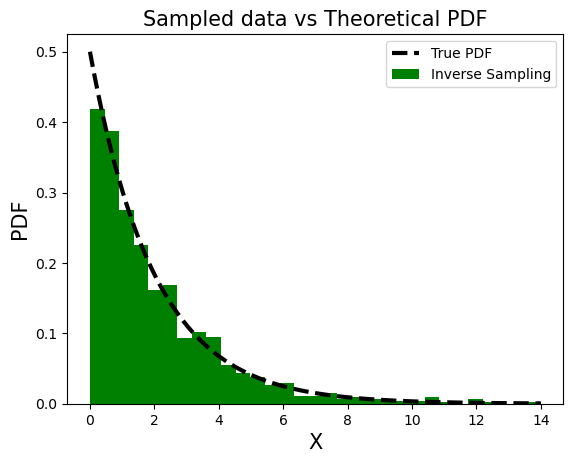

In [2]:
# generate samples and pdf
rate = 0.5
sample_size = 1000
samples = inverse_transform(rate, sample_size)
x_arr = np.linspace(0, 7/rate, sample_size)
pdf = rate*np.exp(-rate*x_arr)

# plot
plt.plot(x_arr, pdf, color='k', linestyle='--', linewidth=3, label ='True PDF')
hist, bins, patches = plt.hist(samples, bins=int(np.sqrt(sample_size)), density=True, color='green', label='Inverse Sampling')
plt.xlabel('X', fontsize=15)
plt.ylabel('PDF', size=15)
plt.legend()
plt.title('Sampled data vs Theoretical PDF', size=15)

# I could add errbars for each bin with sqrt(n) for that bin (each bin is a poisson distrubution)

Usage of AI: AI used to write function doc string

### 3.2 Metropolis Hastings & credible intervals (10 points)



*Topics: Multivariate normal, Metropolis Hastings and marginal distributionsm Credible intervals, Highest posterior density region*

**Reading material: Murphy 5.2.2, 5.2.2.1, 24.3**

We will explore a 2-dim and bimodal probability density function.

In [3]:
# provided

# The likelihood function is given

def pdf_bimodal(x):
    """Bimodal pdf"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/(np.sqrt(2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2).sum()/sigma1**2)  +  0.5/(np.sqrt(2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2).sum()/sigma2**2)
    return pdf


1. Write your own Metropolish Hastings algorithm. (4 points)

- The proposal distribution is supposed to be a $D=2$ dimensional isotropic Gaussian with variance $\sigma^2$.
- Given some pdf, the algorithm should produce and return a given number of chain points $N$, starting with some initial vector $\mathbf{x}_0$. The result should be returned as a $N\times D$ array.
- The algorithm should also evaluate and print the acceptance rate (fraction of accepted transitions over total number of steps).

Hints: Use `np.random.randn`, `np.random.rand`, `np.array` where appropriate. Write the algorithm such that it works for any dimensions of $\mathbf{x}_0$.

In [4]:
def sample_from_2d_gaussian(mean=0, sigma=1):
    x = np.random.normal(mean, sigma)
    y = np.random.normal(mean, sigma)
    return np.asarray([x, y])

def MetropolisHastings(pdf, N, x_init, sigma):

    D = len(x_init) # dimensions 
    theta_current = x_init 
    total_attempts = 0
    samples_chain = np.zeros((N, D))  # Array to store samples

    # start
    for i in range(N):

        # make as many attempts needed until a accepted chain value happens
        accepted = False
        while accepted == False: 
            total_attempts += 1
            # proposal 
            theta_proposed = theta_current + sample_from_2d_gaussian(mean=0, sigma=sigma)

            # calculate acceptence ratio
            acceptance_ratio = min(1, pdf(theta_proposed) / pdf(theta_current))

            # Accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                theta_current = theta_proposed
                
                samples_chain[i,:] = theta_current
                accepted = True 
    
    acceptance_rate = N / total_attempts
    print("Acceptance Rate:", acceptance_rate)

    return samples_chain

2. Explore the above bimodal distribution. (3 points)
- Show resulting chain for $N=10000$ and for five proposal widths in the range $\sigma \in [0.01, 100.]$.  
- Based on the acceptance rate and visual inspection of the result, argue what parameters work here best.
- What are the problems with too low or too high values of $\sigma$?
- Also discuss what happens when you start with initial values far away from the optimum. This initial phase is called "burn in phase".

Hints: use `plt.scatter`

In [5]:
# run walkers
N = 10000
sigma_arr = np.linspace(0.01, 100, 5)
pdf = pdf_bimodal
x_init = np.asarray([0,0])

samples_chain_list = []
for sigma in sigma_arr:
    samples_chain_i = MetropolisHastings(pdf, N, x_init, sigma)
    samples_chain_list.append(samples_chain_i)

Acceptance Rate: 0.9919650828290845
Acceptance Rate: 0.003726014249023691
Acceptance Rate: 0.0009435300118497934
Acceptance Rate: 0.00041786306084274207
Acceptance Rate: 0.00023239563013482503


0
1


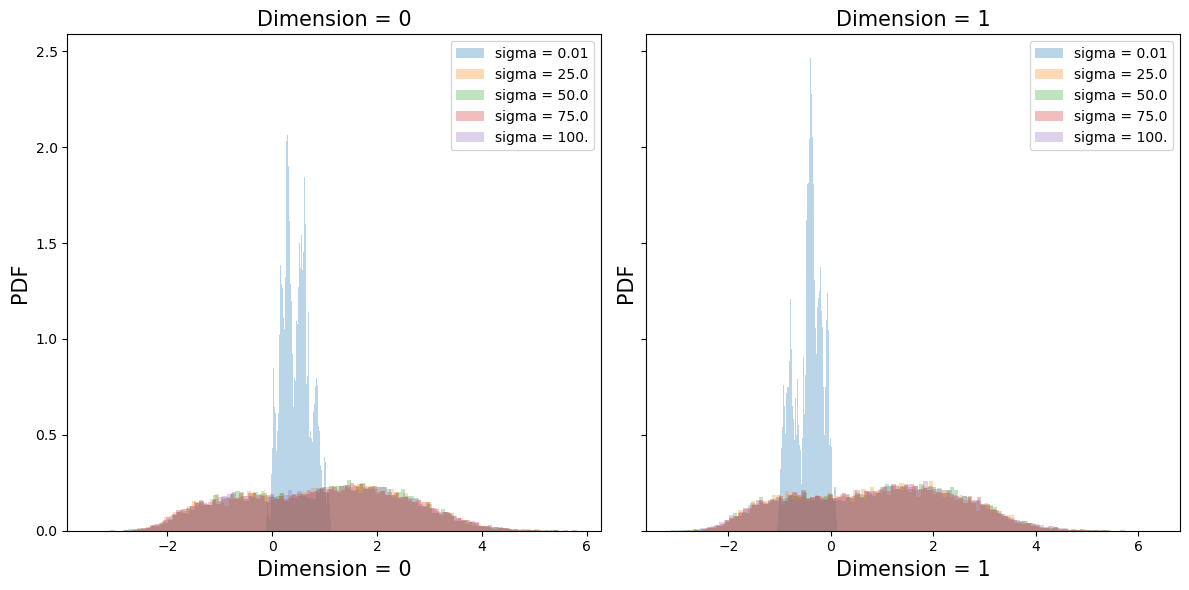

In [11]:
# Set figure size for wider subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot
colors = ['#D81B60', '#FFC107']
# Assuming len(samples_chain_list) is always 2
for i in range(len(samples_chain_list)):
    for j in range(2):
        axs[j].hist(samples_chain_list[i][:,j], density=True, bins=100, alpha=0.3, label='sigma = ' + str(sigma_arr[i])[0:4])
        axs[j].set_xlabel('Dimension = ' + str(j), fontsize=15)
        axs[j].set_ylabel('PDF', fontsize=15)
        axs[j].set_title('Dimension = ' + str(j), fontsize=15)
        axs[j].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

3. Compare your results with the true distribution using 1-dim histograms (both in $x_1$ and $x_2$ direction) (3 points)

- Discuss qualitatively whether the true distribution can be recovered for reasonable values of $\sigma$.
- Again, what happens if $\sigma$ is too large or too small?  Is what you see supporting your observations in the previous question?
- Define a function to generate the one dimensional highest posterior density intervals (HPDI) for both parameters at a certain credible level of a given probability density function. Then, calculate the HPDI for the given bimodal distribution at a $68.5\%$ credible level and plot your results.

Note: you have to write your own marginal distributions for `pdf_bimodal`, projected either on `x1` or on `x2` (do these two marginals differ in our case?).

Hints: use `plt.hist` with 100 bins and `density = True`

In [8]:
pdf_bimodal(np.asarray([0, 0]))

0.0283309862449072

In [9]:


# Define x and y
x = np.linspace(-6, 6, 1000)
y = np.linspace(-6, -6, 1000)

# Assuming mesgrid is a meshgrid
mesh = np.meshgrid(x, y)


samples = pdf_bimodal(mesh)

# Set figure size for wider subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot
colors = ['#D81B60', '#FFC107']
# Assuming len(samples_chain_list) is always 2
for j in range(2):
        axs[j].plot(x, samples, color=colors[j], label='Dimension = ' + str(j))
        axs[j].set_xlabel('x', fontsize=15)
        axs[j].set_ylabel('PDF', fontsize=15)
        axs[j].set_title('Dimension = ' + str(j), fontsize=15)
        axs[j].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [ ]:
# YOUR CODE HERE

Usage of AI: *COMMENT HERE*

### 3.3 Conditional independence and reparametrization (4 points)

*Topics: Independence and Conditional independence*

**Reading material: Murphy 10.1.2**

1. Reparametrization (2 points). In class we introduced the KL divergence
$$
D_{KL}(q \mid p) \equiv \int dx\; q(x) \ln\frac {q(x)}{p(x)}
$$
Show that it is reparametrization invariant, if we replace $x$ with another random variable $y = f(x)$, where $f(x)$ is strictly monotonic and differentiable.  Start by quoting $q(y)$ and $p(y)$ in terms of $q(x)$ and $p(x)$.

YOUR SOLUTION GOES HERE!

2. Conditional independence (2 points). Consider the graphical model defined by $p(x, y, z) = p(x \mid y) p(y \mid z) p(z)$. Show explicitly, by using the relevant definitions, that
- $x$ and $z$ are conditionally independent given $y$
- $z$ and $x$ are conditionally independent given $y$

YOUR SOLUTION!

Usage of AI: *COMMENT HERE*

## Chapter 4: Linear regression (10 points)


### 4.1  Regularized Regression (10 points)


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
#plt.style.use(['dark_background']) # if using dark background, easier to see the plots

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

*Topics: Regularized regression*

**Reading Material: Ref: Murphy 7.5**

1. (2 points) $$\\ $$
Write a method `gen_sine(N)` that generates toy data like in the figure below. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from (0,1), and the elements $t_i$ of $\bt$ are distributed according to
$$t_i \sim \mathcal{N}(\mu_i, \sigma^2),$$
with the mean given by $\mu_i = \sin( 2 \pi x_i)$ and the standard deviation $\sigma=0.25$. Here $x_i$ is the $i$-th element of $\bf{x}$. You can make use of `np.random.normal()`.

Test your function by generating a plot similar to the one below:

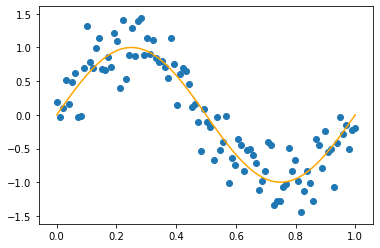

Text(0.5, 1.0, 'Test plot')

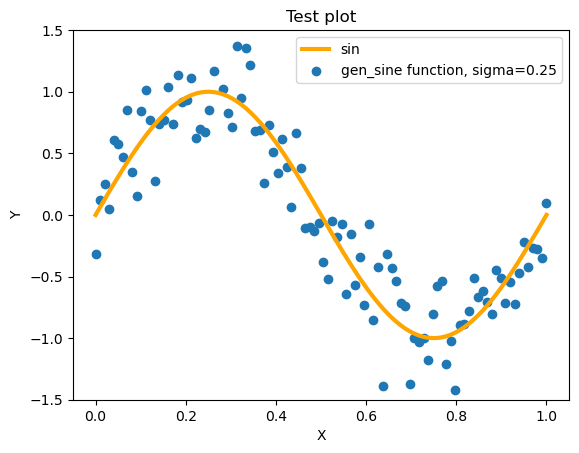

In [52]:
def gen_sine(n, sigma= 0.25):
  """
    Generate a synthetic dataset of sine wave with noise.

    Parameters:
    - n (int): Number of data points to generate.
    - sigma (float, optional): Standard deviation of the Gaussian noise added to the sine wave.
      Default is 0.25.

    Returns:
    - x (ndarray): Array of shape (n,) containing evenly spaced values from 0 to 1.
    - t (ndarray): Array of shape (n,) containing the synthetic sine wave with added noise.
  """
  x = np.linspace(0, 1, n)
  t = np.sin(2*np.pi*x) + np.random.normal(scale=sigma, size=n)
  return x, t

#Test your function
x, t = gen_sine(100)
plt.scatter(x, t, label='gen_sine function, sigma=0.25')
plt.plot(x, np.sin(2*np.pi*x), color='orange', label='sin', linewidth=3)
plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Test plot')

2. (2 points) $$\\ $$  Write a method that finds the regularized $M$-th order polynomial for some fixed dataset $\bx$. Your method should include the regularizer weight $\lambda$ as a parameter and return a vector $\bw$ with the maximum-likelihood parameter estimates.

In [53]:

def fit_polynomial_reg(x, y, M, lambda_reg):
    
    # Example usage:
    # x = np.array([...])  # Input data points
    # y = np.array([...])  # Corresponding target values
    # M = ...             # Order of the polynomial
    # lambda_reg = ...    # Regularization parameter
    # w = fit_polynomial_reg(x, y, M, lambda_reg)
    # print(w)  # Vector of maximum-likelihood parameter estimates

    # Construct the design matrix
    N = len(x)  # Number of data points
    X = np.vander(x, M+1, increasing=True)  # Vandermonde matrix of x

    # Regularization matrix (lambda * I), but don't regularize the bias term (w_0)
    reg_matrix = lambda_reg * np.eye(M+1)
    reg_matrix[0, 0] = 0  # Set the first entry to zero

    # Compute the regularized normal equations
    A = np.dot(X.T, X) + reg_matrix
    b = np.dot(X.T, y)

    # Solve for the weight vector
    w = np.linalg.solve(A, b)
    return w

3. (2 point) $$\\ $$  Use your ``` gen_sine``` method to generate 25 datapoints as "training set", and another 25 datapoints as "test set", under the same conditions as before.  Then, fit polynomials of $M \in (0,2,3,9, 20)$ for values $\lambda = 0$ (unregularized case) to your test set. Plot your results, showing the polynomials, the test and the training set simultaneously.

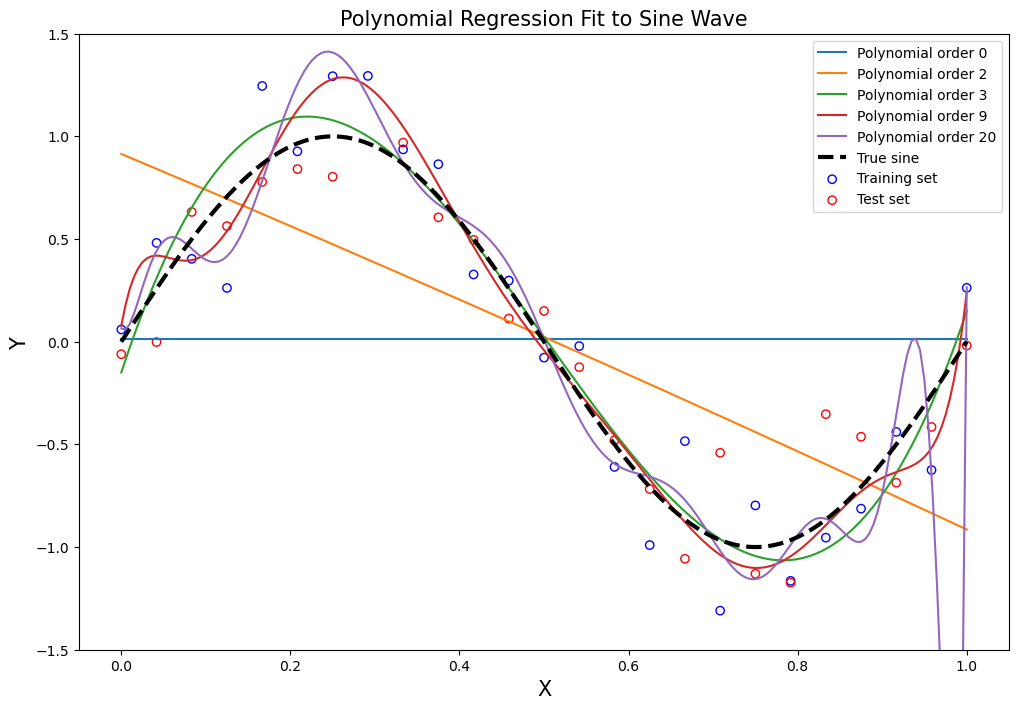

In [59]:


def fit_and_predict(x_train, y_train, x_test, M, lambda_reg=0):
    
    # fit polynomial_reg
    w = fit_polynomial_reg(x_train, y_train, M, lambda_reg)
    
    # Create the design matrix for the test data
    X_test = np.vander(x_test, M + 1, increasing=True)
    
    # Make predictions using the test data
    y_pred = np.dot(X_test, w)
    
    return y_pred


# Generate training and test sets
n_train = n_test = 25
x_train, y_train = gen_sine(n_train)
x_test, y_test = gen_sine(n_test)

# Fit polynomials and plot results
Ms = [0, 2, 3, 9, 20]  # Orders of the polynomial to fit
x_plot = np.linspace(0, 1, 200)  # Points used for plotting the polynomials

plt.figure(figsize=(12, 8))
for M in Ms:
    # Fit polynomial to the training data
    y_plot = fit_and_predict(x_train, y_train, x_plot, M, lambda_reg=0)
    
    # Plot polynomial
    plt.plot(x_plot, y_plot, label=f'Polynomial order {M}')

# Plot training and test sets
plt.scatter(x_train, y_train, facecolors='none', edgecolors='b', label='Training set')
plt.scatter(x_test, y_test, facecolors='none', edgecolors='r', label='Test set')
plt.plot(x_plot, np.sin(2 * np.pi * x_plot), color='k', linestyle='--', label='True sine', linewidth=3)

plt.ylim(-1.5, 1.5)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y',fontsize=15)
plt.legend()
plt.title('Polynomial Regression Fit to Sine Wave', fontsize=15)
plt.show()


4. (2 points)

  For the above fits with $\lambda=0$ (unregularized case) calculate the reduced chi-squared statistics for each $M$ both for the training and the test set.
$$
\chi_\nu^2 = \frac{\chi^2}{\nu},
$$
$$
\chi^2 = \sum_i \frac{(O_i - C_i)^2}{\sigma_i^2}.
$$
Plot the $\chi^2$ values for both training and test set as function of $M$. What do you observe?

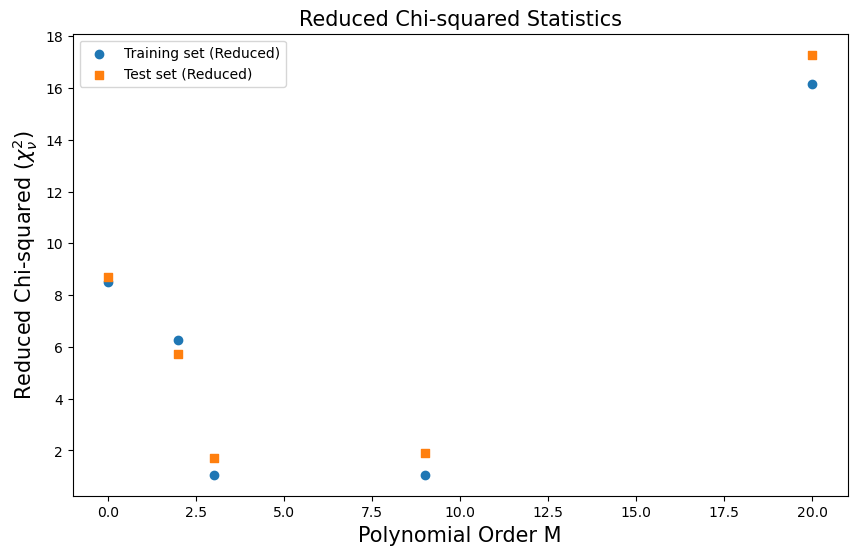

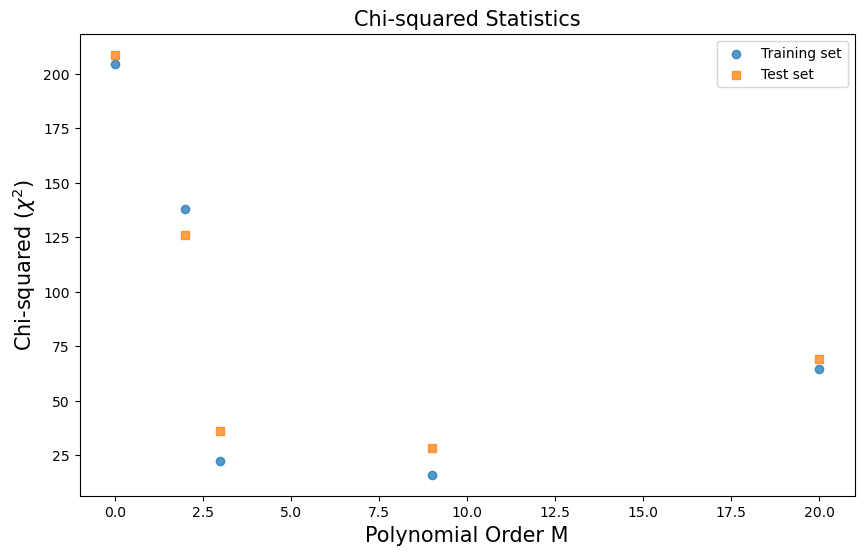

In [58]:
# Assume the noise variance is known, or estimate it from the data

sigma_squared = 0.25**2 # sigma used in the data generation 

train_chi_squared_stats = []
test_chi_squared_stats = []
non_reduced_train_chi_squared_stats = []
non_reduced_test_chi_squared_stats = []

def calculate_chi_squared(y_obs, y_pred, sigma):
    return np.sum(((y_obs - y_pred) / sigma) ** 2)

def calculate_reduced_chi_squared(chi_squared, n_data_points, n_parameters):
    nu = n_data_points - n_parameters
    return chi_squared / nu

for M in Ms:
    # Predictions for training and test sets
    y_train_pred = fit_and_predict(x_train, y_train, x_train, M, lambda_reg=0)
    y_test_pred = fit_and_predict(x_train, y_train, x_test, M, lambda_reg=0)
    
    # Chi-squared for training and test sets
    train_chi_squared = calculate_chi_squared(y_train, y_train_pred, np.sqrt(sigma_squared))
    test_chi_squared = calculate_chi_squared(y_test, y_test_pred, np.sqrt(sigma_squared))
    
    # Reduced chi-squared for training and test sets
    train_reduced_chi_squared = calculate_reduced_chi_squared(train_chi_squared, n_train, M+1)
    test_reduced_chi_squared = calculate_reduced_chi_squared(test_chi_squared, n_test, M+1)
    
    # Save stats for plotting
    train_chi_squared_stats.append(train_reduced_chi_squared)
    test_chi_squared_stats.append(test_reduced_chi_squared)
    non_reduced_train_chi_squared_stats.append(train_chi_squared)
    non_reduced_test_chi_squared_stats.append(test_chi_squared)

# Plotting the reduced chi-squared statistics
plt.figure(figsize=(10, 6))
plt.scatter(Ms, train_chi_squared_stats, label='Training set (Reduced)', marker='o')
plt.scatter(Ms, test_chi_squared_stats, label='Test set (Reduced)', marker='s')
plt.xlabel('Polynomial Order M', fontsize=15)
plt.ylabel('Reduced Chi-squared ($\chi_\\nu^2$)', fontsize=15)
plt.title('Reduced Chi-squared Statistics', fontsize=15)
plt.legend()

plt.show()

# Plotting the non-reduced chi-squared statistics
plt.figure(figsize=(10, 6))
plt.scatter(Ms, non_reduced_train_chi_squared_stats, label='Training set', marker='o', alpha=0.75)
plt.scatter(Ms, non_reduced_test_chi_squared_stats, label='Test set', marker='s', alpha=0.75)
plt.xlabel('Polynomial Order M', fontsize=15)
plt.ylabel('Chi-squared ($\chi^2$)', fontsize=15)
plt.title('Chi-squared Statistics', fontsize=15)
plt.legend()

plt.show()

### Comment:

I'm not sure my sigma_2 value was calculated correctly, nor am I sure how I should calculate that. 

Looks like the best model is M=3, as it gives low chi_2 square value for both test and train data, and is smaller then M=9

5. (2 point) $$\\ $$  For $M=9$, repeat the previous exercise, but instead of varying $M$ you now vary $\lambda\in (0,10^{-5}, 10^{-3}, 10^{-2}, 100)$. Plot and discuss your results.  What is happening to the coefficents $\bw$ as you increase $\lambda$? Which value of $\lambda$ is most appropriate for the model $M=9$? Why?


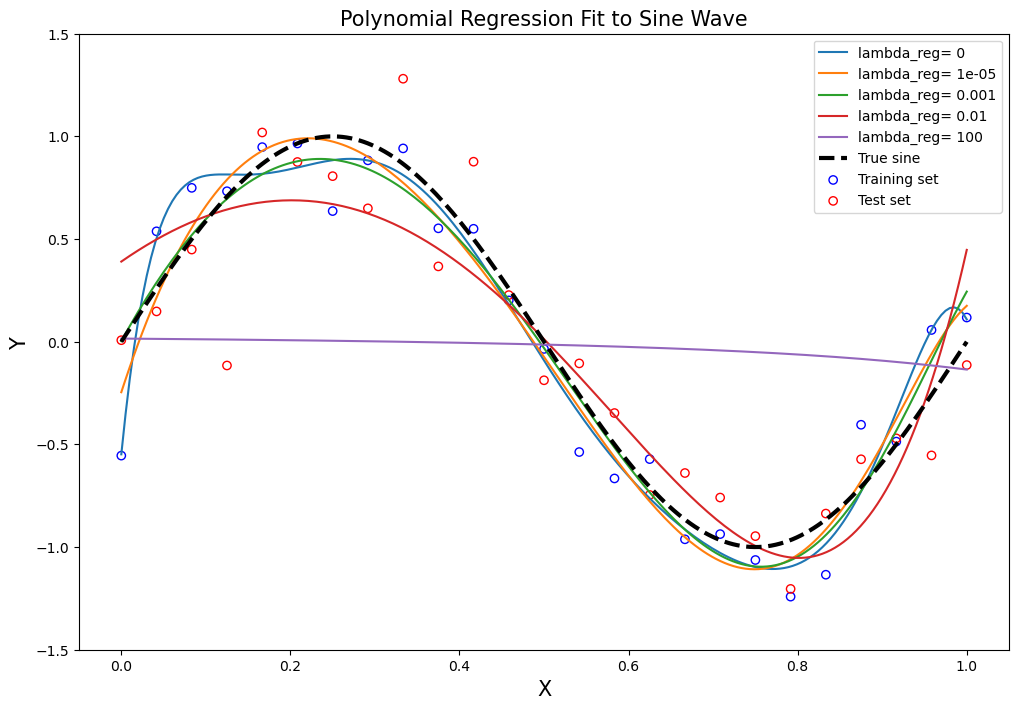

In [61]:
# Generate training and test sets
n_train = n_test = 25
x_train, y_train = gen_sine(n_train)
x_test, y_test = gen_sine(n_test)

# Fit polynomials and plot results
lambas = [0, 1e-5, 1e-3, 1e-2, 100]  # Orders of the polynomial to fit
x_plot = np.linspace(0, 1, 200)  # Points used for plotting the polynomials

plt.figure(figsize=(12, 8))
for i in range(len(lambas)):
    # Fit polynomial to the training data
    M=9
    y_plot = fit_and_predict(x_train, y_train, x_plot, M, lambda_reg=lambas[i])
    
    # Plot polynomial
    plt.plot(x_plot, y_plot, label=f'lambda_reg= {lambas[i]}')

# Plot training and test sets
plt.scatter(x_train, y_train, facecolors='none', edgecolors='b', label='Training set')
plt.scatter(x_test, y_test, facecolors='none', edgecolors='r', label='Test set')
plt.plot(x_plot, np.sin(2 * np.pi * x_plot), color='k', linestyle='--', label='True sine', linewidth=3)

plt.ylim(-1.5, 1.5)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y',fontsize=15)
plt.legend()
plt.title('Polynomial Regression Fit to Sine Wave', fontsize=15)
plt.show()


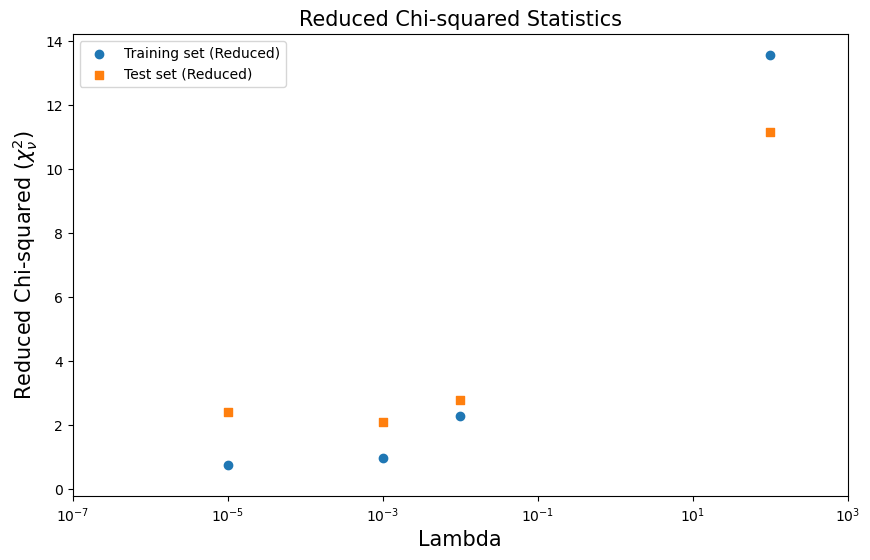

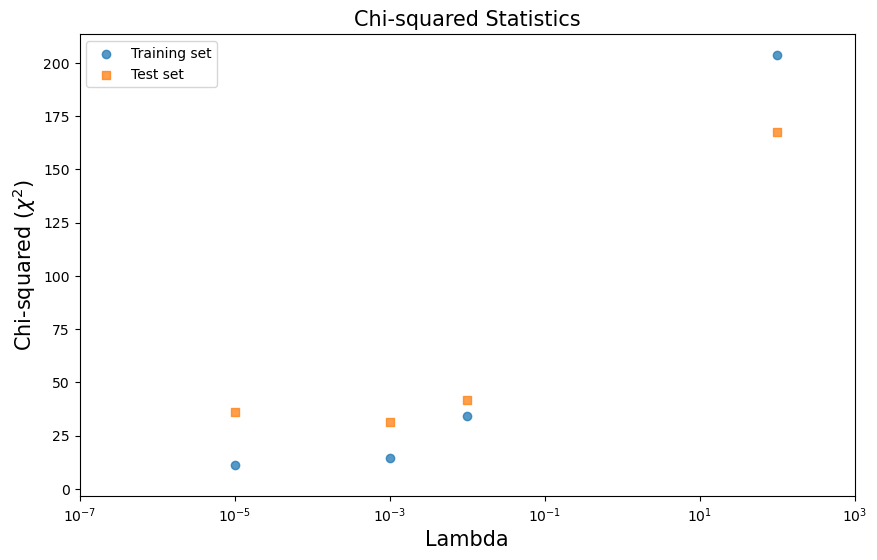

In [67]:
# Assume the noise variance is known, or estimate it from the data

sigma_squared = 0.25**2 # sigma used in the data generation 

train_chi_squared_stats = []
test_chi_squared_stats = []
non_reduced_train_chi_squared_stats = []
non_reduced_test_chi_squared_stats = []



for i in range(len(lambas)):
    # Fit polynomial to the training data
    M=9
    # Predictions for training and test sets
    y_train_pred = fit_and_predict(x_train, y_train, x_train, M, lambda_reg=lambas[i])
    y_test_pred = fit_and_predict(x_train, y_train, x_test, M, lambda_reg=lambas[i])
    
    # Chi-squared for training and test sets
    train_chi_squared = calculate_chi_squared(y_train, y_train_pred, np.sqrt(sigma_squared))
    test_chi_squared = calculate_chi_squared(y_test, y_test_pred, np.sqrt(sigma_squared))
    
    # Reduced chi-squared for training and test sets
    train_reduced_chi_squared = calculate_reduced_chi_squared(train_chi_squared, n_train, M+1)
    test_reduced_chi_squared = calculate_reduced_chi_squared(test_chi_squared, n_test, M+1)
    
    # Save stats for plotting
    train_chi_squared_stats.append(train_reduced_chi_squared)
    test_chi_squared_stats.append(test_reduced_chi_squared)
    non_reduced_train_chi_squared_stats.append(train_chi_squared)
    non_reduced_test_chi_squared_stats.append(test_chi_squared)

# Plotting the reduced chi-squared statistics
plt.figure(figsize=(10, 6))
plt.scatter(lambas, train_chi_squared_stats, label='Training set (Reduced)', marker='o')
plt.scatter(lambas, test_chi_squared_stats, label='Test set (Reduced)', marker='s')
plt.xlabel('Lambda', fontsize=15)
plt.ylabel('Reduced Chi-squared ($\chi_\\nu^2$)', fontsize=15)
plt.title('Reduced Chi-squared Statistics', fontsize=15)
plt.xscale('log')
plt.xlim(1e-7, 1e3)
plt.legend()
plt.show()

# Plotting the non-reduced chi-squared statistics
plt.figure(figsize=(10, 6))
plt.scatter(lambas, non_reduced_train_chi_squared_stats, label='Training set', marker='o', alpha=0.75)
plt.scatter(lambas, non_reduced_test_chi_squared_stats, label='Test set', marker='s', alpha=0.75)
plt.xlabel('Lambda', fontsize=15)
plt.ylabel('Chi-squared ($\chi^2$)', fontsize=15)
plt.title('Chi-squared Statistics', fontsize=15)
plt.xscale('log')
plt.xlim(1e-7, 1e3)
plt.legend()
plt.show()

Usage of AI: *COMMENT HERE*

I used AI to make all the plots, most of the functions and do most of the work. I slightly tweaked a few functions. 

It was very useful in solving for the w coefficients,and and incorporating a lambda argument. 

It was super nice because it knows more numpy then I do, I did not know there is a function to make the matrix